1. Import Library dan Konfigurasi Dasar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Konfigurasi visualisasi agar grafik terlihat rapi
plt.style.use('fivethirtyeight')

2. Pengambilan Dataset

In [ ]:
ticker = 'BBNI.JK'
df = yf.download(ticker, start='2019-01-01', end='2025-01-01')

# Ambil kolom Close dan pastikan formatnya 2D
if isinstance(df.columns, pd.MultiIndex):
    data = df['Close'][ticker].values
else:
    data = df['Close'].values

dataset = data.reshape(-1, 1)

print(f"Shape dataset sekarang: {dataset.shape}")

/tmp/ipython-input-3814152066.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2019-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed

Shape dataset sekarang: (1469, 1)


3. Preprocessing Data

In [ ]:
# 1. Normalisasi data ke skala 0-1 agar training lebih stabi
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 2. Tentukan sliding window menggunakan data 60 hari sebelumnya untuk prediksi
prediction_days = 60

# 3. Bagi data Training dan Testing
training_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# 4. Buat x_train dan y_train
x_train, y_train = [], []

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape untuk input LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("Preprocessing selesai!")

Preprocessing selesai!


4. Membangun Arsitektur LSTM (Sequence Modelling)

In [ ]:
model = Sequential()

# Layer LSTM Pertama dengan Dropout untuk cegah overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Layer LSTM Kedua (return_sequences=False karena ini layer terakhir sebelum output)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully Connected Layer & Output Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5. Training Model

In [ ]:
# Training
history = model.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0405
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0044
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0027
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0031
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0022
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0021
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0020
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0018
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0020
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0017
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0018
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0016
Epoch 13/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0015
Epoch 14/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0015
Epoch 15/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - lo

6. Pengujian dan Prediksi (Data Testing)

In [ ]:
# Buat dataset testing
test_data = scaled_data[training_data_len - prediction_days: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Melakukan Prediksi
predictions = model.predict(x_test)

# Kembalikan ke angka harga asli
predictions = scaler.inverse_transform(predictions)

# Hitung Metrik Evaluasi (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'Root Mean Squared Error (RMSE): {rmse}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Root Mean Squared Error (RMSE): 85.42127189661377


7. Visualisasi Hasil Akhir

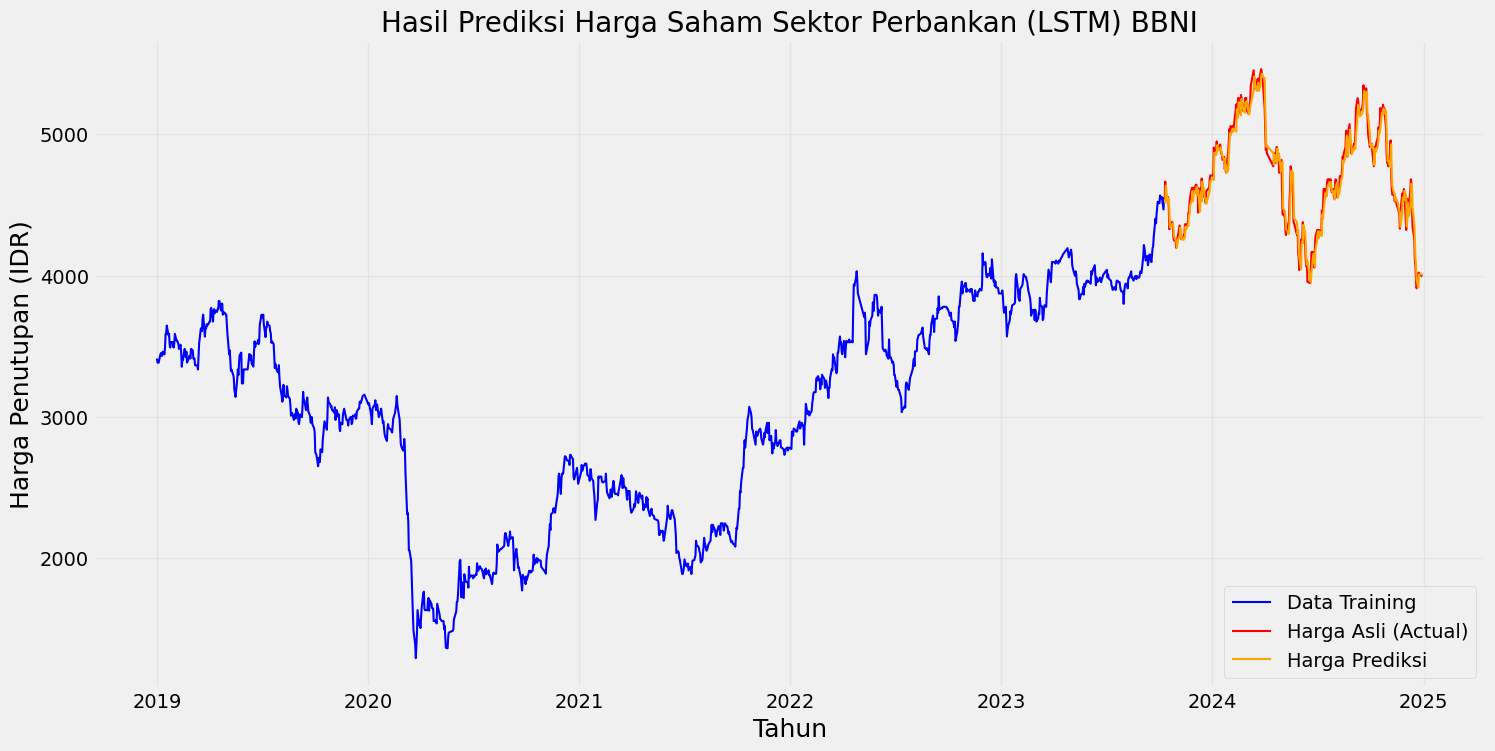

In [ ]:
# 1. Copy DataFrame agar tidak terkena SettingWithCopyWarning/IndexError
train = df[:training_data_len].copy()
valid = df[training_data_len:].copy()

# 2. Masukkan hasil prediksi ke dalam kolom baru
# Kita pastikan jumlah barisnya cocok
valid['Predictions'] = predictions

# 3. Visualisasi
plt.figure(figsize=(16,8))
plt.title('Hasil Prediksi Harga Saham Sektor Perbankan (LSTM) BBNI', fontsize=20)
plt.xlabel('Tahun', fontsize=18)
plt.ylabel('Harga Penutupan (IDR)', fontsize=18)

# Plot Data Latih
plt.plot(train['Close'], color='blue', linewidth=1.5)

# Plot Data Asli vs Prediksi
plt.plot(valid['Close'], color='red', linewidth=1.5)
plt.plot(valid['Predictions'], color='orange', linewidth=1.5)

plt.legend(['Data Training', 'Harga Asli (Actual)', 'Harga Prediksi'], loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

8. Prediksi harga kedepan

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi untuk tanggal 2024-12-31: Rp 3,994


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


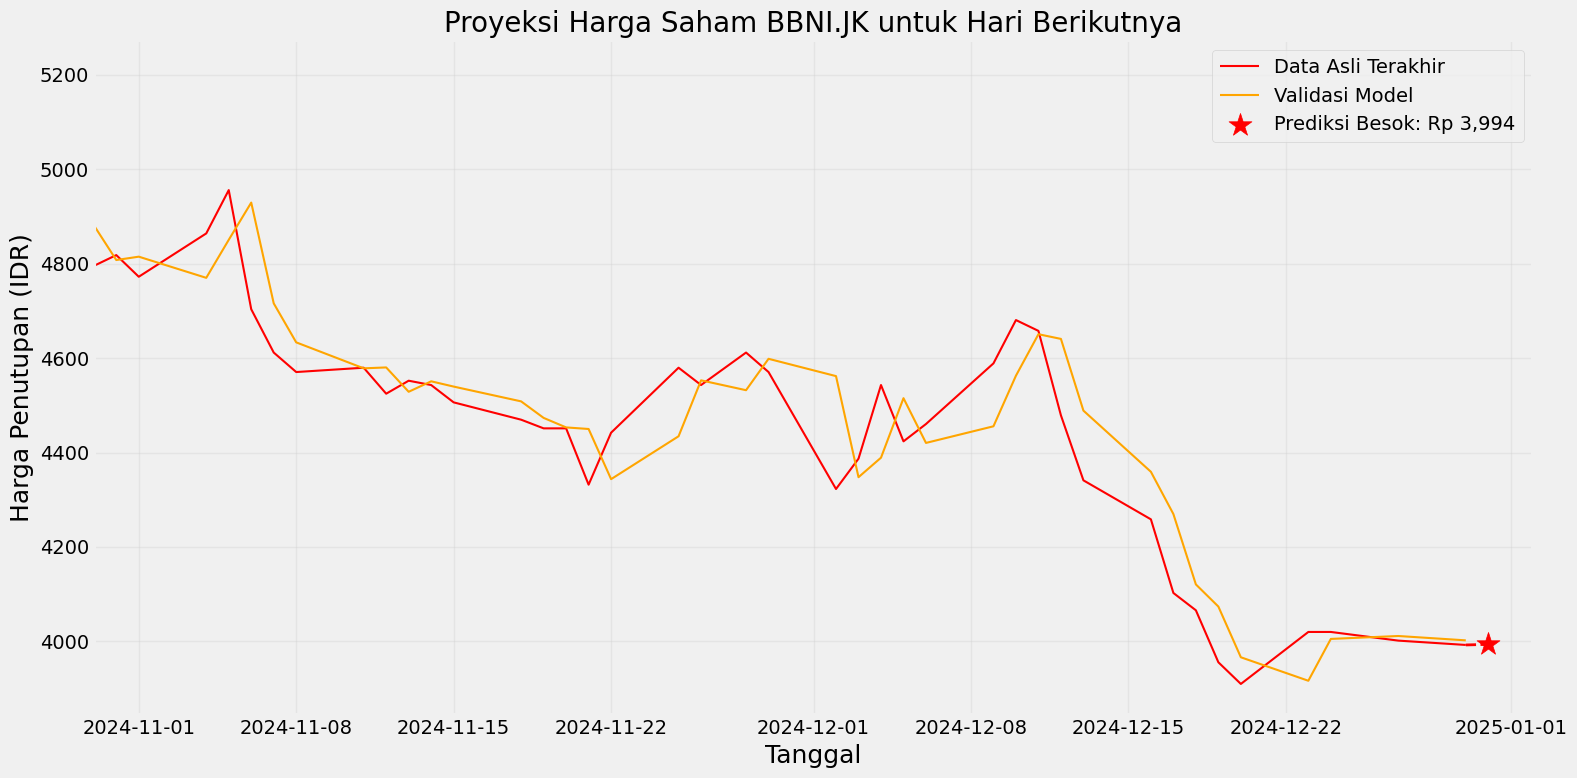

In [ ]:
# 1. PROSES HITUNG PREDIKSI
# Ambil 60 hari terakhir dari data asli untuk prediksi
last_60_days = dataset[-60:]
last_60_days_scaled = scaler.transform(last_60_days)

# Reshape agar sesuai input LSTM [1 sample, 60 timesteps, 1 feature]
X_future = np.array([last_60_days_scaled])
X_future = np.reshape(X_future, (1, 60, 1))

# Prediksi dan kembalikan ke harga asli (Rupiah)
pred_price_scaled = model.predict(X_future)
predicted_next_price = scaler.inverse_transform(pred_price_scaled)[0][0]

# 2. SETUP VISUALISASI
from pandas.tseries.offsets import BusinessDay

# Tentukan tanggal besok (hari kerja berikutnya)
last_date = df.index[-1]
next_date = last_date + BusinessDay(n=1)
print(f"Prediksi untuk tanggal {next_date.date()}: Rp {predicted_next_price:,.0f}")

# Garis putus-putus penghubung dari harga terakhir ke prediksi besok
last_close_price = valid['Close'].iloc[-1]
projection_df = pd.DataFrame({
    'Price': [last_close_price, predicted_next_price]
}, index=[last_date, next_date])

# 3. PLOT GRAFIK
plt.figure(figsize=(16,8))
plt.title(f'Proyeksi Harga Saham {ticker} untuk Hari Berikutnya', fontsize=20)
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Penutupan (IDR)', fontsize=18)

# Plot data asli 2 bulan terakhir
plt.plot(valid['Close'][-60:], color='red', linewidth=1.5, label='Data Asli Terakhir')
plt.plot(valid['Predictions'][-60:], color='orange', linewidth=1.5, label='Validasi Model')

# Plot titik prediksi besok (bintang merah) dan garis proyeksinya
plt.scatter(next_date, predicted_next_price, color='red', marker='*', s=300, zorder=5,
            label=f'Prediksi Besok: Rp {predicted_next_price:,.0f}')
plt.plot(projection_df.index, projection_df['Price'], color='red', linestyle='--', linewidth=2)

plt.xlim(left=last_date - pd.DateOffset(months=2), right=next_date + BusinessDay(n=2))

plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()